<a href="https://colab.research.google.com/github/dannner66/Szakdoga/blob/main/train_schedule_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [308]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder #sklearn

from xgboost import XGBRegressor #xgboost
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt #matplotlib
from xgboost import plot_tree
import xgboost as xgb

from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import KFold
import numpy as np #numpy
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import make_pipeline


# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [309]:
!gdown 1k-FunUld66SiY3cPn6sDBzzmB0qwlItg

Downloading...
From: https://drive.google.com/uc?id=1k-FunUld66SiY3cPn6sDBzzmB0qwlItg
To: /content/sample.xlsx
100% 31.5k/31.5k [00:00<00:00, 48.4MB/s]


In [310]:
pd.set_option('display.max_columns',120)
pd.set_option('display.max_rows',120)

In [311]:
dataset = pd.read_excel('/content/sample.xlsx')
dataset.head()

,train_id,terv_date,terv_ind,terv_erk,ind_stat_terv,ind_nev_terv,erk_stat_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_stat_teny,ind_teny,erk_stat_teny,erk_teny
0,79877,2021-04-11 02:00:00,1970-01-01 11:00:00,1970-01-01 11:09:00,13771,Szajol,13748,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,13771,Szajol,13748,Szolnok
1,102865,2021-09-21 00:00:00,1970-01-01 18:00:00,1970-01-01 18:52:00,10074,Rákos,1081,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,10074,Rákos,1081,Bicske
2,93885,2021-07-23 02:00:00,1970-01-01 23:00:00,1970-01-01 23:16:00,13847,Karcag,13862,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,13847,Karcag,13862,Püspökladány
3,119226,2021-12-19 00:00:00,1970-01-01 10:00:00,1970-01-01 16:14:00,13722,Cegléd,13821,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,13722,Cegléd,13821,Kisújszállás
4,125506,2022-01-30 00:00:00,1970-01-01 17:30:00,1970-01-01 21:26:00,3285,Szabadbattyán,4648,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,3285,Szabadbattyán,4648,Uzsabánya


In [312]:
dataset['train_id'] = dataset['train_id'].astype(str)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   train_id       200 non-null    object
 1   terv_date      200 non-null    object
 2   terv_ind       200 non-null    object
 3   terv_erk       200 non-null    object
 4   ind_stat_terv  200 non-null    int64 
 5   ind_nev_terv   200 non-null    object
 6   erk_stat_terv  200 non-null    int64 
 7   erk__terv      200 non-null    object
 8   teny_ind       200 non-null    object
 9   teny_erk       200 non-null    object
 10  rakom_tom      200 non-null    int64 
 11  vonathossz     200 non-null    int64 
 12  vontat_mode    91 non-null     object
 13  vonatnem       200 non-null    object
 14  ind_stat_teny  200 non-null    int64 
 15  ind_teny       200 non-null    object
 16  erk_stat_teny  200 non-null    int64 
 17  erk_teny       200 non-null    object
dtypes: int64(6), object(12)
memory

In [313]:
#print(dataset['terv_ind'])
def concat_terv(data):

  for idx, row in data.iterrows():
        tmp_date = str(data.at[idx, 'terv_date']).split(" ")[0] + ' ' + str(data.at[idx, 'terv_ind']).split(" ")[1]
        data.at[idx, 'terv_ind'] = pd.to_datetime(tmp_date)
        tmp_date = str(data.at[idx, 'terv_date']).split(" ")[0] + ' ' + str(data.at[idx, 'terv_erk']).split(" ")[1]
        data.at[idx, 'terv_erk'] = pd.to_datetime(tmp_date)
  return data

In [314]:
concat_terv(dataset)

,train_id,terv_date,terv_ind,terv_erk,ind_stat_terv,ind_nev_terv,erk_stat_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_stat_teny,ind_teny,erk_stat_teny,erk_teny
0,79877,2021-04-11 02:00:00,2021-04-11 11:00:00,2021-04-11 11:09:00,13771,Szajol,13748,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,13771,Szajol,13748,Szolnok
1,102865,2021-09-21 00:00:00,2021-09-21 18:00:00,2021-09-21 18:52:00,10074,Rákos,1081,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,10074,Rákos,1081,Bicske
2,93885,2021-07-23 02:00:00,2021-07-23 23:00:00,2021-07-23 23:16:00,13847,Karcag,13862,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,13847,Karcag,13862,Püspökladány
3,119226,2021-12-19 00:00:00,2021-12-19 10:00:00,2021-12-19 16:14:00,13722,Cegléd,13821,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,13722,Cegléd,13821,Kisújszállás
4,125506,2022-01-30 00:00:00,2022-01-30 17:30:00,2022-01-30 21:26:00,3285,Szabadbattyán,4648,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,3285,Szabadbattyán,4648,Uzsabánya
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,207788,2023-06-29 00:00:00,2023-06-29 11:00:00,2023-06-29 11:30:00,11445,Szerencs,13284,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,11445,Szerencs,13284,Tállya
196,209006,2023-07-15 00:00:00,2023-07-15 16:17:00,2023-07-15 16:57:00,17137,Kiskunfélegyháza,16311,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,17137,Kiskunfélegyháza,16311,Kiskunhalas
197,223395,2023-12-15 00:00:00,2023-12-15 01:00:00,2023-12-15 01:26:00,10025,Ferencváros,10082,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,10025,Ferencváros,10082,Rákosrendező
198,227451,2024-02-13 00:00:00,2024-02-13 16:00:00,2024-02-13 16:55:00,11395,Felsőzsolca,11296,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,11395,Felsőzsolca,11296,Füzesabony


In [315]:
dataset.drop('ind_stat_teny', axis=1, inplace=True)
dataset.drop('ind_stat_terv', axis=1, inplace=True)
dataset.drop('erk_stat_teny', axis=1, inplace=True)
dataset.drop('erk_stat_terv', axis=1, inplace=True)
dataset.drop('terv_date', axis=1, inplace=True)
dataset.drop('train_id', axis=1, inplace=True)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   terv_ind      200 non-null    object
 1   terv_erk      200 non-null    object
 2   ind_nev_terv  200 non-null    object
 3   erk__terv     200 non-null    object
 4   teny_ind      200 non-null    object
 5   teny_erk      200 non-null    object
 6   rakom_tom     200 non-null    int64 
 7   vonathossz    200 non-null    int64 
 8   vontat_mode   91 non-null     object
 9   vonatnem      200 non-null    object
 10  ind_teny      200 non-null    object
 11  erk_teny      200 non-null    object
dtypes: int64(2), object(10)
memory usage: 18.9+ KB


In [316]:
dataset[dataset['terv_ind'] == dataset['terv_erk']]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny


In [317]:
dataset = dataset[dataset['teny_ind'] != dataset['teny_erk']].copy()

In [318]:


def extract_date(data):

    data['terv_ind'] = pd.to_datetime(data['terv_ind'],format="%Y-%m-%d %H:%M:%S")
    data['terv_ind_Year'] = data.terv_ind.dt.year
    data['terv_ind_Month'] = data.terv_ind.dt.month
    data['terv_ind_Day'] = data.terv_ind.dt.day
    data['terv_ind_Hour'] = data.terv_ind.dt.hour
    data['terv_ind_Minute'] = data.terv_ind.dt.minute
    data['terv_ind_Second'] = data.terv_ind.dt.second
    data['terv_ind_WeekOfYear'] = data.terv_ind.dt.isocalendar().week

    data['terv_erk'] = pd.to_datetime(data['terv_erk'],format="%Y-%m-%d %H:%M:%S")
    data['terv_erk_Year'] = data.terv_erk.dt.year
    data['terv_erk_Month'] = data.terv_erk.dt.month
    data['terv_erk_Day'] = data.terv_erk.dt.day
    data['terv_erk_Hour'] = data.terv_erk.dt.hour
    data['terv_erk_Minute'] = data.terv_erk.dt.minute
    data['terv_erk_Second'] = data.terv_erk.dt.second
    data['terv_erk_WeekOfYear'] = data.terv_erk.dt.isocalendar().week

    data['teny_ind'] = pd.to_datetime(data['teny_ind'],format="%Y-%m-%d %H:%M:%S")
    data['teny_ind_Year'] = data.teny_ind.dt.year
    data['teny_ind_Month'] = data.teny_ind.dt.month
    data['teny_ind_Day'] = data.teny_ind.dt.day
    data['teny_ind_Hour'] = data.teny_ind.dt.hour
    data['teny_ind_Minute'] = data.teny_ind.dt.minute
    data['teny_ind_Second'] = data.teny_ind.dt.second
    data['teny_ind_WeekOfYear'] = data.teny_ind.dt.isocalendar().week

    data['teny_erk'] = pd.to_datetime(data['teny_erk'],format="%Y-%m-%d %H:%M:%S")
    data['teny_erk_Year'] = data.teny_erk.dt.year
    data['teny_erk_Month'] = data.teny_erk.dt.month
    data['teny_erk_Day'] = data.teny_erk.dt.day
    data['teny_erk_Hour'] = data.teny_erk.dt.hour
    data['teny_erk_Minute'] = data.teny_erk.dt.minute
    data['teny_erk_Second'] = data.teny_erk.dt.second
    data['teny_erk_WeekOfYear'] = data.teny_erk.dt.isocalendar().week
    #data.drop('terv_ind', axis=1, inplace=True)
    #data.drop('terv_erk', axis=1, inplace=True)
    #data.drop('teny_ind', axis=1, inplace=True)
    #data.drop('teny_erk', axis=1, inplace=True)
    #data.drop('terv_date', axis=1, inplace=True)

In [319]:
extract_date(dataset)

In [320]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   terv_ind             200 non-null    datetime64[ns]
 1   terv_erk             200 non-null    datetime64[ns]
 2   ind_nev_terv         200 non-null    object        
 3   erk__terv            200 non-null    object        
 4   teny_ind             200 non-null    datetime64[ns]
 5   teny_erk             200 non-null    datetime64[ns]
 6   rakom_tom            200 non-null    int64         
 7   vonathossz           200 non-null    int64         
 8   vontat_mode          91 non-null     object        
 9   vonatnem             200 non-null    object        
 10  ind_teny             200 non-null    object        
 11  erk_teny             200 non-null    object        
 12  terv_ind_Year        200 non-null    int32         
 13  terv_ind_Month       200 non-null  

In [321]:
dataset = dataset[dataset.rakom_tom >= 0].copy()
dataset = dataset[dataset.vonathossz >= 0].copy()

dataset[dataset.terv_erk == ""]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear


In [322]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   terv_ind             200 non-null    datetime64[ns]
 1   terv_erk             200 non-null    datetime64[ns]
 2   ind_nev_terv         200 non-null    object        
 3   erk__terv            200 non-null    object        
 4   teny_ind             200 non-null    datetime64[ns]
 5   teny_erk             200 non-null    datetime64[ns]
 6   rakom_tom            200 non-null    int64         
 7   vonathossz           200 non-null    int64         
 8   vontat_mode          91 non-null     object        
 9   vonatnem             200 non-null    object        
 10  ind_teny             200 non-null    object        
 11  erk_teny             200 non-null    object        
 12  terv_ind_Year        200 non-null    int32         
 13  terv_ind_Month       200 non-null  

In [323]:
def duration(data):
    # Calculate the timedeltas
    travel_time_terv = data['terv_erk'] - data['terv_ind']
    travel_time_teny = data['teny_erk'] - data['teny_ind']

    # Calculate days, hours, and minutes for terv
    data['travel_time_terv'] = (travel_time_terv.dt.seconds // 3600)*60 + (travel_time_terv.dt.seconds % 3600) // 60
    # Calculate days, hours, and minutes for teny (if needed)
    data['travel_time_teny'] = (travel_time_teny.dt.seconds // 3600)*60 + (travel_time_teny.dt.seconds % 3600) // 60
    return data


In [324]:
import datetime
def arrival_repair(data):

    tmp_str_date = ''
    for idx, row in data.iterrows():
        if row['terv_erk'] <= row['terv_ind']:
            data.at[idx, 'terv_erk'] += datetime.timedelta(days=1)
        tmp_str_date = str(data.at[idx,'terv_erk_Year']) +'-'+ str(data.at[idx,'terv_erk_Month']) + '-' + str(data.at[idx,'terv_erk_Day']) + ' ' + str(data.at[idx,'terv_erk_Hour']) + ':' + str(data.at[idx,'terv_erk_Minute']) + ':' + str(data.at[idx,'terv_erk_Second'])
        data.at[idx,  'terv_erk'] = pd.to_datetime(tmp_str_date,dayfirst=True)
        if row['teny_erk'] <= row['teny_ind']:
            data.at[idx, 'teny_erk'] += datetime.timedelta(days=1)
        tmp_str_date = str(data.at[idx,'teny_erk_Year']) +'-'+ str(data.at[idx,'teny_erk_Month']) + '-' + str(data.at[idx,'teny_erk_Day']) + ' ' + str(data.at[idx,'teny_erk_Hour']) + ':' + str(data.at[idx,'teny_erk_Minute']) + ':' + str(data.at[idx,'teny_erk_Second'])
        data.at[idx,  'teny_erk'] = pd.to_datetime(tmp_str_date, dayfirst=True)

    return data

In [325]:
dataset

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
0,2021-04-11 11:00:00,2021-04-11 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7


In [326]:
dataset_min_change = dataset.copy()
arrival_repair(dataset)

<ipython-input-324-50dd1000db31>:9: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data.at[idx,  'terv_erk'] = pd.to_datetime(tmp_str_date,dayfirst=True)
<ipython-input-324-50dd1000db31>:13: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data.at[idx,  'teny_erk'] = pd.to_datetime(tmp_str_date, dayfirst=True)


,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
0,2021-04-11 11:00:00,2021-11-04 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-11-04 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7


In [327]:
duration(dataset)

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny
0,2021-04-11 11:00:00,2021-11-04 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-11-04 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14,9,1430
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38,52,399
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29,16,1394
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51,374,954
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5,236,1189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26,30,54
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28,40,85
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50,26,73
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7,55,98


In [328]:
dataset = dataset[dataset.travel_time_teny > 5].copy()
dataset = dataset[dataset.travel_time_terv > 5].copy()

In [329]:
dataset[dataset.travel_time_teny < 0]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny


In [330]:
dataset[dataset.travel_time_terv <= 0]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny


In [331]:
dataset['rakom_tom'] = dataset['rakom_tom'].astype(int)
dataset['vonathossz'] = dataset['vonathossz'].astype(int)
dataset

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny
0,2021-04-11 11:00:00,2021-11-04 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-11-04 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14,9,1430
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38,52,399
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29,16,1394
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51,374,954
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5,236,1189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26,30,54
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28,40,85
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50,26,73
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7,55,98


In [332]:
dataset.columns

Index(['terv_ind', 'terv_erk', 'ind_nev_terv', 'erk__terv', 'teny_ind',
       'teny_erk', 'rakom_tom', 'vonathossz', 'vontat_mode', 'vonatnem',
       'ind_teny', 'erk_teny', 'terv_ind_Year', 'terv_ind_Month',
       'terv_ind_Day', 'terv_ind_Hour', 'terv_ind_Minute', 'terv_ind_Second',
       'terv_ind_WeekOfYear', 'terv_erk_Year', 'terv_erk_Month',
       'terv_erk_Day', 'terv_erk_Hour', 'terv_erk_Minute', 'terv_erk_Second',
       'terv_erk_WeekOfYear', 'teny_ind_Year', 'teny_ind_Month',
       'teny_ind_Day', 'teny_ind_Hour', 'teny_ind_Minute', 'teny_ind_Second',
       'teny_ind_WeekOfYear', 'teny_erk_Year', 'teny_erk_Month',
       'teny_erk_Day', 'teny_erk_Hour', 'teny_erk_Minute', 'teny_erk_Second',
       'teny_erk_WeekOfYear', 'travel_time_terv', 'travel_time_teny'],
      dtype='object')

In [333]:
input_cols = ['ind_nev_terv', 'rakom_tom',
       'vonathossz', 'vontat_mode', 'vonatnem', 'ind_teny', 'erk_teny',
       'terv_ind_Year', 'terv_ind_Month', 'terv_ind_Day', 'terv_ind_Hour',
       'terv_ind_Minute', 'terv_ind_Second', 'terv_ind_WeekOfYear',
       'terv_erk_Year', 'terv_erk_Month', 'terv_erk_Day', 'terv_erk_Hour',
       'terv_erk_Minute', 'terv_erk_Second', 'terv_erk_WeekOfYear',
       'teny_ind_Year', 'teny_ind_Month', 'teny_ind_Day', 'teny_ind_Hour',
       'teny_ind_Minute', 'teny_ind_Second', 'teny_ind_WeekOfYear',
       'teny_erk_Year', 'teny_erk_Month', 'teny_erk_Day', 'teny_erk_Hour',
       'teny_erk_Minute', 'teny_erk_Second', 'teny_erk_WeekOfYear',
       'travel_time_terv']
target_col = ['travel_time_teny']

In [334]:
x = dataset[input_cols].copy()
y = dataset[target_col].copy()

In [335]:

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30)
inputs = x_train
targets = y_train
test_inputs = x_test
test_inputs

,ind_nev_terv,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv
49,Szolnok-Rendező,0,20,NaN,M,Szolnok-Rendező,Rákoshegy,2020,10,14,7,0,0,42,2020,10,14,8,8,0,42,2020,10,13,20,25,0,42,2020,10,14,11,56,0,42,68
173,Békéscsaba,0,16,NaN,M,Békéscsaba,Lőkösháza,2022,10,28,8,32,0,43,2022,10,28,9,10,0,43,2022,10,28,6,35,0,43,2022,10,28,7,56,0,43,38
122,Ferencv.Nyugati.r.,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,9,18,22,30,0,37,2022,9,18,22,49,0,37,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19
170,Soroksári út rendező,0,229,tmDiesel,T,Soroksári út rendező,Rajka,2021,12,23,20,7,0,51,2021,12,23,2,32,0,51,2021,12,23,20,58,0,51,2021,12,24,2,20,0,51,385
50,Tata,0,20,tmDiesel,M,Tata,Komárom-Rendező,2020,11,9,3,30,0,46,2020,11,9,3,47,0,46,2020,11,9,2,55,0,46,2020,11,9,2,40,0,46,17
104,Ferencv.Nyugati.r.,592960,179,tmDiesel,T,Ferencv.Nyugati.r.,Baja,2022,1,23,23,0,0,3,2022,1,23,5,59,0,3,2022,1,23,22,55,0,3,2022,1,24,9,32,0,4,419
22,Kiskunfélegyháza,1448000,369,NaN,T,Kiskunfélegyháza,Balotaszállás elágazás,2024,2,23,0,30,0,8,2024,2,23,1,16,0,8,2024,2,22,21,32,0,8,2024,2,23,16,0,0,8,46
44,Soroksár-Terminál,0,38,NaN,M,Soroksár-Terminál,Ferencváros,2023,10,20,19,14,0,42,2023,10,20,19,28,0,42,2023,10,21,0,19,0,42,2023,10,21,5,39,0,42,14
88,Biatorbágy,0,388,NaN,T,Biatorbágy,Budaörs,2023,11,19,21,0,0,46,2023,11,19,21,12,0,46,2023,11,19,21,4,0,46,2023,11,20,4,40,0,47,12
6,Győrszentiván,679090,627,tmElectric,T,Győrszentiván,Soroksár-Terminál,2022,7,11,19,0,0,28,2022,7,11,21,56,0,28,2022,7,11,13,19,0,28,2022,7,12,4,54,0,28,176


In [336]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(140, 36)
(60, 36)
(140, 1)
(60, 1)


In [337]:
numeric_cols = ['rakom_tom','vonathossz',
       'terv_ind_Year', 'terv_ind_Month', 'terv_ind_Day', 'terv_ind_Hour',
       'terv_ind_Minute', 'terv_ind_Second', 'terv_ind_WeekOfYear',
       'terv_erk_Year', 'terv_erk_Month', 'terv_erk_Day', 'terv_erk_Hour',
       'terv_erk_Minute', 'terv_erk_Second', 'terv_erk_WeekOfYear',
       'teny_ind_Year', 'teny_ind_Month', 'teny_ind_Day', 'teny_ind_Hour',
       'teny_ind_Minute', 'teny_ind_Second', 'teny_ind_WeekOfYear',
       'teny_erk_Year', 'teny_erk_Month', 'teny_erk_Day', 'teny_erk_Hour',
       'teny_erk_Minute', 'teny_erk_Second', 'teny_erk_WeekOfYear',
       'travel_time_terv']
categorical_cols = ['ind_nev_terv', 'vontat_mode', 'vonatnem','ind_teny','erk_teny']

**Adatelemzés**

In [338]:
data_analysis = dataset

In [339]:
data_analysisNum = data_analysis[numeric_cols]

In [340]:
#Leíró statisztika
data_analysisNum.describe()

,rakom_tom,vonathossz,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv
count,2.000000e+02,200.000000,200.0000,200.000000,200.000000,200.000000,200.00000,200.0,200.0,200.0000,200.000000,200.000000,200.000000,200.000000,200.0,200.0,200.0000,200.000000,200.000000,200.000000,200.000000,200.0,200.0,200.0000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000
mean,2.397027e+05,143.070000,2022.5700,7.210000,16.550000,15.425000,11.74000,0.0,29.455,2022.5700,7.210000,16.550000,14.370000,30.740000,0.0,29.455,2022.5700,6.715000,17.275000,14.670000,27.335000,0.0,27.41,2022.5700,6.730000,17.110000,13.560000,25.110000,0.230000,27.475,99.700000
std,3.944748e+05,154.899692,0.9216,3.542406,8.795699,6.594072,15.37839,0.0,15.255544,0.9216,3.542406,8.795699,7.481508,17.285437,0.0,15.255544,0.9216,3.494975,8.201567,6.853169,16.469639,0.0,15.111043,0.9216,3.488257,8.292268,7.140823,17.537838,2.545486,15.12492,134.739055
min,0.000000e+00,12.000000,2020.0000,1.000000,1.000000,0.000000,0.00000,0.0,1.0,2020.0000,1.000000,1.000000,0.000000,0.000000,0.0,1.0,2020.0000,1.000000,1.000000,0.000000,0.000000,0.0,1.0,2020.0000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,6.000000
25%,0.000000e+00,20.000000,2022.0000,4.000000,9.000000,10.000000,0.00000,0.0,15.0,2022.0000,4.000000,9.000000,8.000000,15.750000,0.0,15.0,2022.0000,4.000000,11.000000,10.000000,14.000000,0.0,15.0,2022.0000,4.000000,10.750000,8.000000,14.000000,0.000000,15.0,19.000000
50%,0.000000e+00,61.000000,2023.0000,8.000000,17.500000,17.500000,0.00000,0.0,33.0,2023.0000,8.000000,17.500000,16.000000,30.500000,0.0,33.0,2023.0000,6.000000,20.000000,16.000000,27.000000,0.0,25.5,2023.0000,6.000000,20.000000,14.000000,20.000000,0.000000,25.5,44.000000
75%,5.647600e+05,208.000000,2023.0000,10.000000,23.250000,22.000000,30.00000,0.0,43.0,2023.0000,10.000000,23.250000,21.250000,49.000000,0.0,43.0,2023.0000,10.000000,22.000000,21.000000,38.000000,0.0,42.25,2023.0000,10.000000,23.000000,21.000000,39.000000,0.000000,42.25,117.750000
max,1.752200e+06,627.000000,2024.0000,12.000000,31.000000,23.000000,55.00000,0.0,52.0,2024.0000,12.000000,31.000000,23.000000,59.000000,0.0,52.0,2024.0000,12.000000,31.000000,23.000000,59.000000,0.0,52.0,2024.0000,12.000000,31.000000,23.000000,59.000000,34.000000,52.0,901.000000


In [341]:
#Hiányzó adatok elemzése
missing_data = data_analysis.isnull().sum()
print(missing_data)

terv_ind                 0
terv_erk                 0
ind_nev_terv             0
erk__terv                0
teny_ind                 0
teny_erk                 0
rakom_tom                0
vonathossz               0
vontat_mode            109
vonatnem                 0
ind_teny                 0
erk_teny                 0
terv_ind_Year            0
terv_ind_Month           0
terv_ind_Day             0
terv_ind_Hour            0
terv_ind_Minute          0
terv_ind_Second          0
terv_ind_WeekOfYear      0
terv_erk_Year            0
terv_erk_Month           0
terv_erk_Day             0
terv_erk_Hour            0
terv_erk_Minute          0
terv_erk_Second          0
terv_erk_WeekOfYear      0
teny_ind_Year            0
teny_ind_Month           0
teny_ind_Day             0
teny_ind_Hour            0
teny_ind_Minute          0
teny_ind_Second          0
teny_ind_WeekOfYear      0
teny_erk_Year            0
teny_erk_Month           0
teny_erk_Day             0
teny_erk_Hour            0
t

<Axes: title={'center': 'Monthly Actual Departures'}, xlabel='teny_ind_month'>

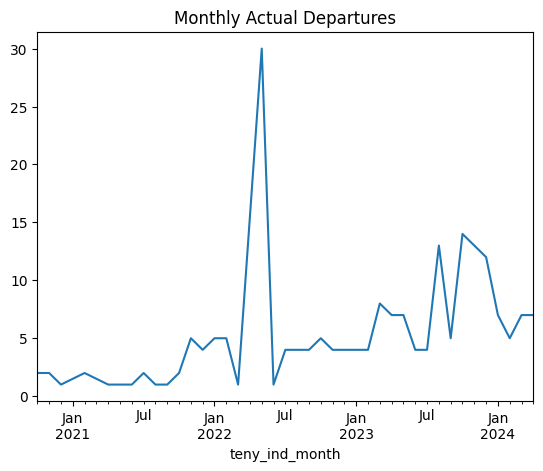

In [342]:
#Idősor elemzés
data_analysis['teny_ind_month'] = data_analysis['teny_ind'].dt.to_period('M')
monthly_departures = data_analysis.groupby('teny_ind_month').size()
monthly_departures.plot(kind='line', title='Monthly Actual Departures')

In [343]:
# Összehasonlító elemzés: terv vs teny
data_analysis['departure_delay'] = abs((data_analysis['teny_ind'] - data_analysis['terv_ind']).dt.total_seconds() / 60)  # in minutes
print(data_analysis['departure_delay'].describe())

count       200.000000
mean      20985.365000
std       59204.724243
min           0.000000
25%          59.750000
50%         137.000000
75%         541.000000
max      282292.000000
Name: departure_delay, dtype: float64


In [344]:
data_analysis[data_analysis["departure_delay"] > 50000]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny,teny_ind_month,departure_delay
110,2022-06-26 22:30:00,2022-06-26 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,6,26,22,30,0,25,2022,6,26,22,49,0,25,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,50452.0
111,2022-07-03 22:30:00,2022-03-07 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,3,22,30,0,26,2022,7,3,22,49,0,26,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,60532.0
112,2022-07-10 22:30:00,2022-10-07 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,10,22,30,0,27,2022,7,10,22,49,0,27,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,70612.0
113,2022-07-17 22:30:00,2022-07-17 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,17,22,30,0,28,2022,7,17,22,49,0,28,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,80692.0
114,2022-07-24 22:30:00,2022-07-24 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,24,22,30,0,29,2022,7,24,22,49,0,29,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,90772.0
115,2022-07-31 22:30:00,2022-07-31 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,31,22,30,0,30,2022,7,31,22,49,0,30,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,100852.0
116,2022-08-07 22:30:00,2022-07-08 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,7,22,30,0,31,2022,8,7,22,49,0,31,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,110932.0
117,2022-08-14 22:30:00,2022-08-14 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,14,22,30,0,32,2022,8,14,22,49,0,32,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,121012.0
118,2022-08-21 22:30:00,2022-08-21 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,21,22,30,0,33,2022,8,21,22,49,0,33,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,131092.0
119,2022-08-28 22:30:00,2022-08-28 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,28,22,30,0,34,2022,8,28,22,49,0,34,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,141172.0


In [345]:
# Compare scheduled and actual travel times
data_analysis['travel_time_difference'] = abs(data_analysis['travel_time_teny'] - data_analysis['travel_time_terv'])
print(data_analysis['travel_time_difference'].describe())

count     200.000000
mean      404.575000
std       461.055719
min         2.000000
25%        30.750000
50%       143.000000
75%       687.250000
max      1421.000000
Name: travel_time_difference, dtype: float64


In [346]:
# Correlation matrix for certain variables
correlation_matrix = data_analysis[['rakom_tom', 'vonathossz', 'travel_time_terv','travel_time_teny']].corr()
print(correlation_matrix)

                  rakom_tom  vonathossz  travel_time_terv  travel_time_teny
rakom_tom          1.000000    0.516777          0.017875         -0.058879
vonathossz         0.516777    1.000000          0.171116         -0.043113
travel_time_terv   0.017875    0.171116          1.000000          0.357295
travel_time_teny  -0.058879   -0.043113          0.357295          1.000000


In [347]:
# Analysis of train types and their frequencies
train_type_distribution = data_analysis['vonatnem'].value_counts()
print(train_type_distribution)

vonatnem
T     102
M      97
Gt      1
Name: count, dtype: int64


In [348]:
# Average actual travel time by train type
average_travel_time_by_type = data_analysis.groupby('vonatnem')['travel_time_teny'].mean()
print(average_travel_time_by_type)

vonatnem
Gt    813.000000
M     587.597938
T     399.460784
Name: travel_time_teny, dtype: float64


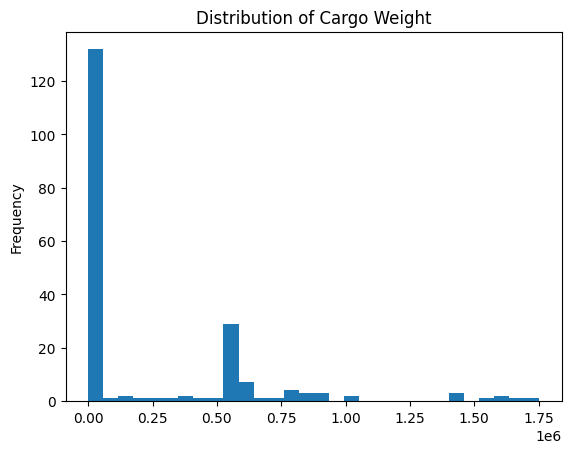

In [349]:
# Histogram for 'rakom_tom'
data_analysis['rakom_tom'].plot(kind='hist', bins=30, title='Distribution of Cargo Weight')
plt.show()

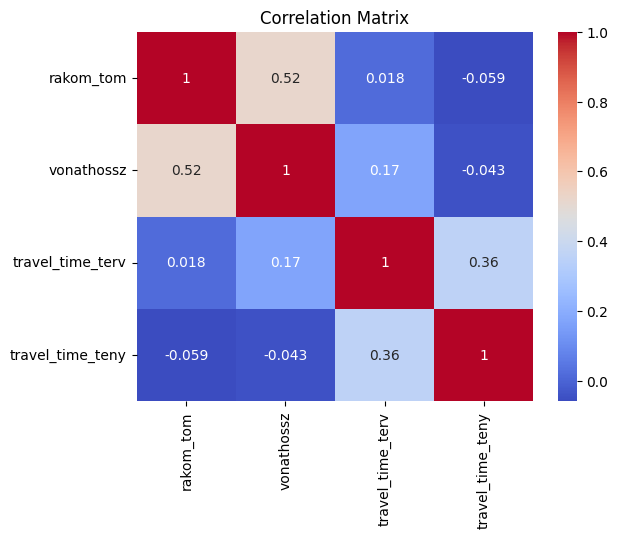

In [350]:
# Heat map for correlations
import seaborn as sns

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Normalizálás

In [351]:
dataset.drop('terv_ind', axis=1, inplace=True)
dataset.drop('terv_erk', axis=1, inplace=True)
dataset.drop('teny_ind', axis=1, inplace=True)
dataset.drop('teny_erk', axis=1, inplace=True)

In [352]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

OneHotEncoding


In [353]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-353-a4fce10cc6af>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
<ipython-input-353-a4fce10cc6af>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs[encoded_cols] = encoder.tr

In [354]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [355]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=50, max_depth=4)

In [356]:
%%time
model.fit(X, targets)

CPU times: user 644 ms, sys: 6.51 ms, total: 650 ms
Wall time: 1.18 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [357]:
preds = model.predict(X)

In [358]:
def mse(a, b):
  return mean_squared_error(a, b, squared=True)

In [359]:
def mae(a, b):
  return mean_absolute_error(a,b)

In [360]:
xgbRegressorTrainMSE = mse(preds, targets)
xgbRegressorTrainMAE = mae(preds, targets)


print("mse (train): ",mse(preds, targets))
print("mae (train): ",mae(preds, targets))

preds_test = model.predict(X_test)

xgbRegressorTestMSE = mse(preds_test, y_test)
xgbRegressorTestMAE = mae(preds_test, y_test)

print("mse (train): ",mse(preds_test, y_test))
print("mae (train): ",mae(preds_test, y_test))

mse (train):  1408.2170771990095
mae (train):  26.391661180768693
mse (train):  223459.96544031374
mae (train):  322.5011644999186


In [361]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head()

,feature,importance
30,travel_time_terv,0.137965
51,ind_nev_terv_Kiskunhalas,0.117518
49,ind_nev_terv_Karcag,0.095803
6,terv_ind_Minute,0.076613
3,terv_ind_Month,0.055856


In [362]:
X = inputs[importance_df[importance_df.importance > 0.001].feature].copy()
X_test = test_inputs[importance_df[importance_df.importance > 0.001].feature].copy()

In [363]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=50, max_depth=4)

In [364]:
%%time
model.fit(X, targets)

CPU times: user 859 ms, sys: 5.14 ms, total: 864 ms
Wall time: 2.26 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [365]:
preds = model.predict(X)

In [366]:
xgbRegressorImportantTrainMSE = mse(preds, targets)
xgbRegressorImportantTrainMAE = mae(preds, targets)

print("mse: ",mse(preds, targets))
print("mae: ",mae(preds, targets))

mse:  1030.278554183159
mae:  22.595896625518797


In [367]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head()

,feature,importance
2,ind_nev_terv_Karcag,0.115057
4,terv_ind_Month,0.079176
5,erk_teny_Soroksár,0.079022
3,terv_ind_Minute,0.073668
0,travel_time_terv,0.062468


In [368]:
def train_and_evaluateMSE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)
    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)
    return model, train_mse, val_mse

In [369]:
def train_and_evaluateMAE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)
    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)
    return model, train_mae, val_mae

In [370]:
kfold = KFold(n_splits=5)

In [371]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mse, val_mse = train_and_evaluateMSE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MSE: {}'.format(train_mse, val_mse))

Train MSE: 1640.4896784427933, Validation MSE: 293170.60265114077
Train MSE: 7052.929732938688, Validation MSE: 236150.5285460769
Train MSE: 6362.683468376411, Validation MSE: 136851.13289399885
Train MSE: 3631.6228811089177, Validation MSE: 327794.8869235312
Train MSE: 5499.664589046796, Validation MSE: 144714.78434588626


In [372]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mae, val_mae = train_and_evaluateMAE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MAE: {}'.format(train_mae, val_mae))

Train MSE: 29.243695957320078, Validation MAE: 417.39314610617504
Train MSE: 60.428114482334685, Validation MAE: 317.2968044281006
Train MSE: 58.56067020552499, Validation MAE: 263.3837007795061
Train MSE: 42.695013633796144, Validation MAE: 406.8116431917463
Train MSE: 52.68558529445103, Validation MAE: 240.45190858840942


In [373]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [374]:
preds = predict_avg(models, X_train)
preds

array([ 115.155685,  923.5841  ,  284.74622 ,  289.26947 , 1068.8986  ,
        975.8244  ,   41.19251 ,  472.51074 ,  172.01741 ,  246.81436 ,
       1030.714   ,  334.64062 ,   41.19251 ,  445.396   ,  347.25726 ,
        299.90585 , 1131.926   ,  438.42856 ,  108.37154 ,  366.91132 ,
        441.30536 ,   47.916473,   94.00482 ,  360.26483 ,  212.24532 ,
       1087.9812  ,  383.03104 , 1171.4241  ,   40.737766,   54.929085,
         67.60102 ,  344.03784 , 1011.2479  ,   40.737766,   49.56029 ,
       1056.1566  ,   52.771423, 1051.331   ,  215.50737 ,  482.3292  ,
        105.773026, 1075.0491  ,  360.54034 ,  296.3051  ,   49.153023,
         48.15996 , 1057.1266  ,  891.56555 ,  635.5487  ,  709.5844  ,
        497.5726  , 1257.7772  ,  257.82803 ,   44.23897 ,  105.33657 ,
        101.20432 ,  335.36786 ,  697.34924 ,   70.02229 ,  499.5997  ,
         48.371216,   81.054306, 1027.6628  ,  243.68062 ,   73.442245,
        106.57312 ,   94.76144 ,  248.11467 ,   41.19251 ,  115.

In [375]:
drop_col = ["ind_nev_terv", "vontat_mode", "vonatnem", "ind_teny", "erk_teny"]
inputs.drop(drop_col, axis = 1, inplace = True)
test_inputs.drop(drop_col, axis = 1, inplace = True)


In [376]:
from sklearn.model_selection import RandomizedSearchCV


# ## Hyper Parameter Optimization
# n_estimators = [50, 75, 100, 200]
# max_depth = [2, 3, 5, 10, 15]
# learning_rate=[0.05,0.1,0.15,0.2]
# min_child_weight=[1,2,3,4]

# # Define the grid of hyperparameters to search
# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'max_depth':max_depth,
#     'learning_rate':learning_rate,
#     'min_child_weight':min_child_weight
#     }

# # Set up the random search with 4-fold cross validation
# random_cv = RandomizedSearchCV(estimator=model,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=50,
#             scoring = 'neg_mean_absolute_error',n_jobs = 5,
#             verbose = 5,
#             return_train_score = True,
#             random_state=42)

# random_cv.fit(inputs,targets)

# print(random_cv.best_estimator_)

In [378]:
def train_and_evaluateMSE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)

    return model, train_mse, val_mse

In [380]:
def train_and_evaluateMAE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)
    model.fit(X_train, train_targets)

    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)

    return model, train_mae, val_mae

In [382]:
kfold = KFold(n_splits=5)
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mse, val_mse = train_and_evaluateMSE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MSE: {}'.format(train_mse, val_mse))

Train MSE: 1.529517378782787e-07, Validation MSE: 420960.84198041726
Train MSE: 1.638806890826215e-07, Validation MSE: 274995.39217130566
Train MSE: 1.909437433563913e-07, Validation MSE: 355006.8762243693
Train MSE: 1.6452320648698203e-07, Validation MSE: 411256.03608146857
Train MSE: 1.740584545067187e-07, Validation MSE: 365529.73723996704


In [384]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mae, val_mae = train_and_evaluateMAE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MAE: {}'.format(train_mae, val_mae))

Train MSE: 0.00031447410583496094, Validation MAE: 449.35365649632047
Train MSE: 0.00032413857323782783, Validation MAE: 315.82058606828963
Train MSE: 0.00035043273653302876, Validation MAE: 406.1500259126936
Train MSE: 0.0003274679183959961, Validation MAE: 426.91624232700894
Train MSE: 0.00033471414021083286, Validation MAE: 363.7013487134661


In [385]:
regressor = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

regressor.fit(inputs,targets)
y_pred = regressor.predict(test_inputs)

In [386]:
test_pred = regressor.predict(test_inputs)

xgbRegressorGsHptTestMSE = mse(test_pred, y_test)
xgbRegressorGsHptTestMAE =  mae(test_pred, y_test)

print("mse: ",mse(test_pred, y_test))
print("mae: ",mae(test_pred, y_test))

mse:  365902.85799111065
mae:  414.30135679244995


In [387]:
train_pred = regressor.predict(inputs)

xgbRegressorGsHptTrainMSE = mse(train_pred, targets)
xgbRegressorGsHptTrainMAE =  mae(train_pred, targets)

print("mse: ",mse(train_pred, targets))
print("mae: ",mae(train_pred, targets))

mse:  1.58224254067006e-07
mae:  0.00032217161996023994


In [388]:
test_targets_xgb = y_test
test_targets_xgb["test_pred"] = test_pred

#4377
idx = dataset_min_change.index.intersection(test_inputs.index)
print(idx)
dataset_min_changeXGB = dataset_min_change.loc[idx]
dataset_min_changeXGB["y_test"] = test_targets_xgb["travel_time_teny"]
dataset_min_changeXGB["predicted_travel_time"] = test_targets_xgb["test_pred"]
dataset_min_changeXGB.to_csv('submissionXGB.csv', index=None)

Index([  1,   3,   4,   6,   7,  10,  11,  12,  13,  14,  15,  16,  18,  20,
        21,  22,  25,  36,  37,  40,  44,  47,  49,  50,  51,  56,  57,  62,
        69,  72,  74,  76,  77,  79,  80,  88,  92, 104, 110, 111, 112, 114,
       116, 119, 122, 126, 128, 131, 137, 139, 141, 163, 164, 167, 170, 173,
       175, 181, 185, 193],
      dtype='int64')


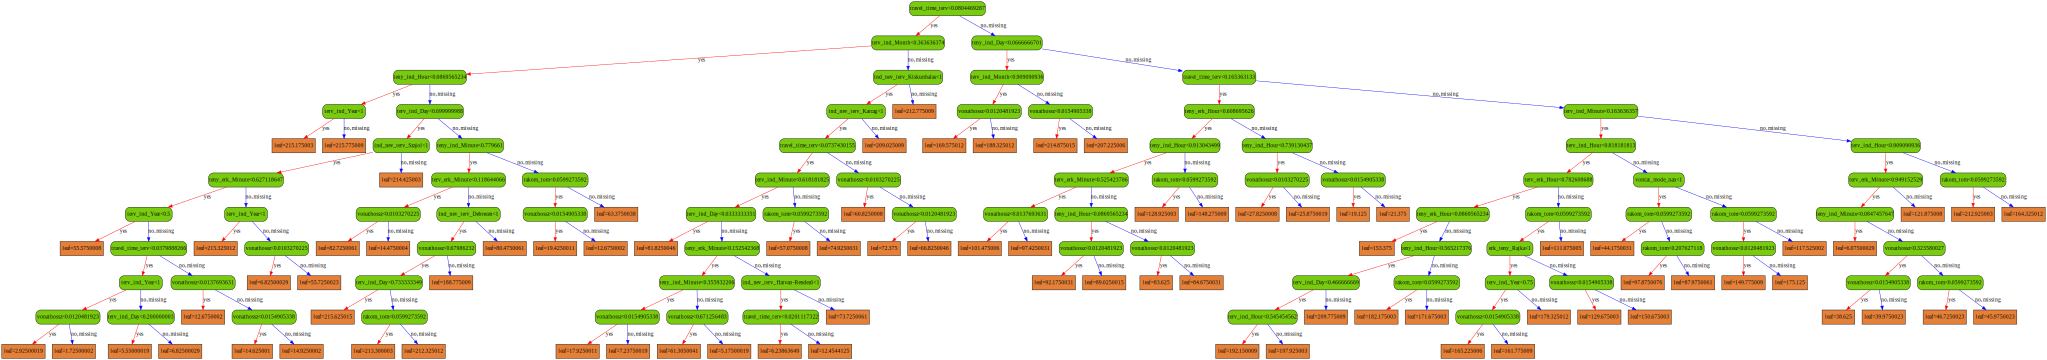

In [389]:
node_params = {
    'shape':'box',
    'style':'filled, rounded',
    'fillcolor':'#78cbe'
}
leaf_params = {
    'shape':'box',
    'style':'filled',
    'fillcolor':'#e48038'
}
image = xgb.to_graphviz(regressor, num_trees=0,size="1,1", condition_node_params=node_params, leaf_node_params=leaf_params)
image.graph_attr = {'dpi':'400'}
image.render('xgb_individualtree', format = 'png')
image

In [390]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

y_test.drop('test_pred', axis = 1, inplace = True)

model = RandomForestRegressor(random_state=1)
model.fit(inputs, targets)
predicted_values = model.predict(test_inputs)
predicted_valuesTrain = model.predict(inputs)

randomForestRegressorTrainMSE = metrics.mean_squared_error(targets, predicted_valuesTrain)
randomForestRegressorTrainMAE = metrics.mean_absolute_error(targets, predicted_valuesTrain)
randomForestRegressorTestMSE = metrics.mean_squared_error(y_test, predicted_values)
randomForestRegressorTestMAE = metrics.mean_absolute_error(y_test, predicted_values)

print("mean squared error (train): ",metrics.mean_squared_error(targets, predicted_valuesTrain))
print("mean squared error (test): ",metrics.mean_squared_error(y_test, predicted_values))
print("mean absolute error (train): ",metrics.mean_absolute_error(targets, predicted_valuesTrain))
print("mean absolute error (test): ",metrics.mean_absolute_error(y_test, predicted_values))

<ipython-input-390-8733fe88dc6c>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(inputs, targets)


mean squared error (train):  28658.57133
mean squared error (test):  213030.14719500003
mean absolute error (train):  113.07857142857142
mean absolute error (test):  307.06983333333335


In [391]:
predicted_values

array([ 266.56,  143.36,   36.  ,  863.84,  132.54,  760.06,  705.92,
        514.08,  116.95,  845.05,   36.  ,   36.  ,  332.39,   36.  ,
        689.9 ,  993.38,  929.78,  688.99,  972.82,  120.79,  711.09,
        106.17,  357.51,  980.88,   36.  ,  372.9 ,  111.16,   99.95,
         36.03,  977.49,  769.75,  909.92,  760.05,  461.14,  147.43,
        698.59,  313.23,  533.97,  235.74,  199.19,  575.63,  106.68,
        302.51,  199.75,  132.31,   36.  ,  797.42,  943.23,  385.22,
         36.  ,  896.27, 1025.59, 1070.73,  229.75,  738.22,  212.04,
         36.  ,   36.  ,  614.71, 1078.01])

In [392]:
test_targets = y_test
test_targets["predicted_values"] = predicted_values
test_targets

,travel_time_teny,predicted_values
49,931,266.56
173,81,143.36
122,36,36.00
170,322,863.84
50,1425,132.54
104,637,760.06
22,1108,705.92
44,320,514.08
88,456,116.95
6,935,845.05


In [393]:
dataset_min_change

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
0,2021-04-11 11:00:00,2021-04-11 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7


In [394]:
#4525
idx = dataset_min_change.index.intersection(test_inputs.index)
print(idx)

Index([  1,   3,   4,   6,   7,  10,  11,  12,  13,  14,  15,  16,  18,  20,
        21,  22,  25,  36,  37,  40,  44,  47,  49,  50,  51,  56,  57,  62,
        69,  72,  74,  76,  77,  79,  80,  88,  92, 104, 110, 111, 112, 114,
       116, 119, 122, 126, 128, 131, 137, 139, 141, 163, 164, 167, 170, 173,
       175, 181, 185, 193],
      dtype='int64')


In [395]:
dataset_min_change = dataset_min_change.loc[idx]

In [396]:
dataset_min_change["y_test"] = test_targets["travel_time_teny"]
dataset_min_change["predicted_travel_time"] = test_targets["predicted_values"]

In [397]:
dataset_min_change

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,y_test,predicted_travel_time
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38,399,235.74
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51,954,972.82
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5,1189,711.09
6,2022-07-11 19:00:00,2022-07-11 21:56:00,Győrszentiván,Soroksár-Terminál,2022-07-11 13:19:00,2022-07-12 04:54:00,679090,627,tmElectric,T,Győrszentiván,Soroksár-Terminál,2022,7,11,19,0,0,28,2022,7,11,21,56,0,28,2022,7,11,13,19,0,28,2022,7,12,4,54,0,28,935,845.05
7,2022-11-15 01:00:00,2022-11-15 01:54:00,Kiskunhalas,Kiskunfélegyháza,2022-11-15 09:02:00,2022-11-15 08:07:00,0,21,NaN,M,Kiskunhalas,Kiskunfélegyháza,2022,11,15,1,0,0,46,2022,11,15,1,54,0,46,2022,11,15,9,2,0,46,2022,11,15,8,7,0,46,1385,385.22
10,2023-11-23 20:53:00,2023-11-23 23:44:00,Tatabánya,Dunakeszi,2023-11-23 21:14:00,2023-11-24 17:56:00,1584060,407,tmDieselVillany,T,Tatabánya,Dunakeszi,2023,11,23,20,53,0,47,2023,11,23,23,44,0,47,2023,11,23,21,14,0,47,2023,11,24,17,56,0,47,1242,760.05
11,2023-03-25 06:00:00,2023-03-25 09:48:00,Szolnok-Rendező,Tiszapalkonya-Erőmű,2023-03-24 21:00:00,2023-03-25 10:49:00,0,20,NaN,M,Szolnok-Rendező,Tiszapalkonya-Erőmű,2023,3,25,6,0,0,12,2023,3,25,9,48,0,12,2023,3,24,21,0,0,12,2023,3,25,10,49,0,12,829,1025.59
12,2023-12-03 15:00:00,2023-12-03 15:34:00,Nyíregyháza,Debrecen,2023-12-03 14:30:00,2023-12-03 14:25:00,0,18,NaN,M,Nyíregyháza,Debrecen,2023,12,3,15,0,0,48,2023,12,3,15,34,0,48,2023,12,3,14,30,0,48,2023,12,3,14,25,0,48,1435,106.68
13,2023-05-04 08:00:00,2023-05-04 08:26:00,Nagykanizsa,Gyékényes,2023-05-04 07:20:00,2023-05-04 07:00:00,0,17,NaN,M,Nagykanizsa,Gyékényes,2023,5,4,8,0,0,18,2023,5,4,8,26,0,18,2023,5,4,7,20,0,18,2023,5,4,7,0,0,18,1420,212.04
14,2023-05-31 16:00:00,2023-05-31 22:13:00,Nagykanizsa,Hidasnémeti,2023-05-31 18:00:00,2023-06-01 09:30:00,0,20,NaN,M,Nagykanizsa,Hidasnémeti,2023,5,31,16,0,0,22,2023,5,31,22,13,0,22,2023,5,31,18,0,0,22,2023,6,1,9,30,0,22,930,896.27


In [398]:
dataset_min_change.columns

Index(['terv_ind', 'terv_erk', 'ind_nev_terv', 'erk__terv', 'teny_ind',
       'teny_erk', 'rakom_tom', 'vonathossz', 'vontat_mode', 'vonatnem',
       'ind_teny', 'erk_teny', 'terv_ind_Year', 'terv_ind_Month',
       'terv_ind_Day', 'terv_ind_Hour', 'terv_ind_Minute', 'terv_ind_Second',
       'terv_ind_WeekOfYear', 'terv_erk_Year', 'terv_erk_Month',
       'terv_erk_Day', 'terv_erk_Hour', 'terv_erk_Minute', 'terv_erk_Second',
       'terv_erk_WeekOfYear', 'teny_ind_Year', 'teny_ind_Month',
       'teny_ind_Day', 'teny_ind_Hour', 'teny_ind_Minute', 'teny_ind_Second',
       'teny_ind_WeekOfYear', 'teny_erk_Year', 'teny_erk_Month',
       'teny_erk_Day', 'teny_erk_Hour', 'teny_erk_Minute', 'teny_erk_Second',
       'teny_erk_WeekOfYear', 'y_test', 'predicted_travel_time'],
      dtype='object')

In [399]:
dataset_min_change.to_csv('submissionRFR.csv', index=None)

In [400]:
parameters = {
    'n_estimators': [50,100,150,200],
    'max_depth': [item for item in range(3, 15+1)]
}

In [401]:
#inputs = x_train
#targets = y_train
#test_inputs = x_test
from sklearn.model_selection import GridSearchCV
# clf = GridSearchCV(model, parameters)
# gs  = clf.fit(inputs, targets.values.ravel())
# print(gs.best_params_)

In [402]:
model = RandomForestRegressor(random_state=1, max_depth=15, n_estimators=200)
model.fit(inputs, targets)

<ipython-input-402-39e41942ea37>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(inputs, targets)


RandomForestRegressor(max_depth=15, n_estimators=200, random_state=1)

In [403]:
y_pred_train = model.predict(inputs)

randomForestRegressorGsHptTrainMSE = metrics.mean_squared_error(targets, y_pred_train)
randomForestRegressorGsHptTrainMAE = metrics.mean_absolute_error(targets, y_pred_train)

print("mse: ",metrics.mean_squared_error(targets, y_pred_train))
print("mae: ",metrics.mean_absolute_error(targets, y_pred_train))

mse:  28133.350985698802
mae:  112.97122458460478


In [404]:
y_test.drop('travel_time_teny', axis=1, inplace=True)
y_pred = model.predict(test_inputs)


randomForestRegressorGsHptTestMSE = metrics.mean_squared_error(y_test, y_pred)
randomForestRegressorGsHptTestMAE = metrics.mean_absolute_error(y_test, y_pred)

print("mse: ",metrics.mean_squared_error(y_test, y_pred))
print("mae: ",metrics.mean_absolute_error(y_test, y_pred))


mse:  502.46566820689236
mae:  16.500387754652248


In [405]:
print(y_test)

     predicted_values
49             266.56
173            143.36
122             36.00
170            863.84
50             132.54
104            760.06
22             705.92
44             514.08
88             116.95
6              845.05
119             36.00
112             36.00
185            332.39
126             36.00
167            689.90
15             993.38
37             929.78
16             688.99
3              972.82
80             120.79
4              711.09
36             106.17
141            357.51
79             980.88
131             36.00
25             372.90
92             111.16
175             99.95
111             36.03
69             977.49
40             769.75
20             909.92
10             760.05
139            461.14
163            147.43
76             698.59
193            313.23
77             533.97
1              235.74
164            199.19
56             575.63
12             106.68
181            302.51
18             199.75
137       

In [406]:
dataset[numeric_cols] = scaler.transform(dataset[numeric_cols])

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(dataset[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
dataset[encoded_cols] = encoder.transform(dataset[categorical_cols])
X_test = dataset[numeric_cols + encoded_cols]
clf = model.fit(X_test, y)
all_pred = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-406-432563adf575>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[encoded_cols] = encoder.transform(dataset[categorical_cols])
<ipython-input-406-432563adf575>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[encoded_cols] = encoder

In [407]:
randomForestTreeGsHptAllMSE =  metrics.mean_squared_error(y, all_pred)
randomForestTreeGsHptAllMAE =  metrics.mean_absolute_error(y, all_pred)
print("mse: ",metrics.mean_squared_error(y, all_pred))
print("mae: ",metrics.mean_absolute_error(y, all_pred))

mse:  27037.67073180387
mae:  117.63421702769502


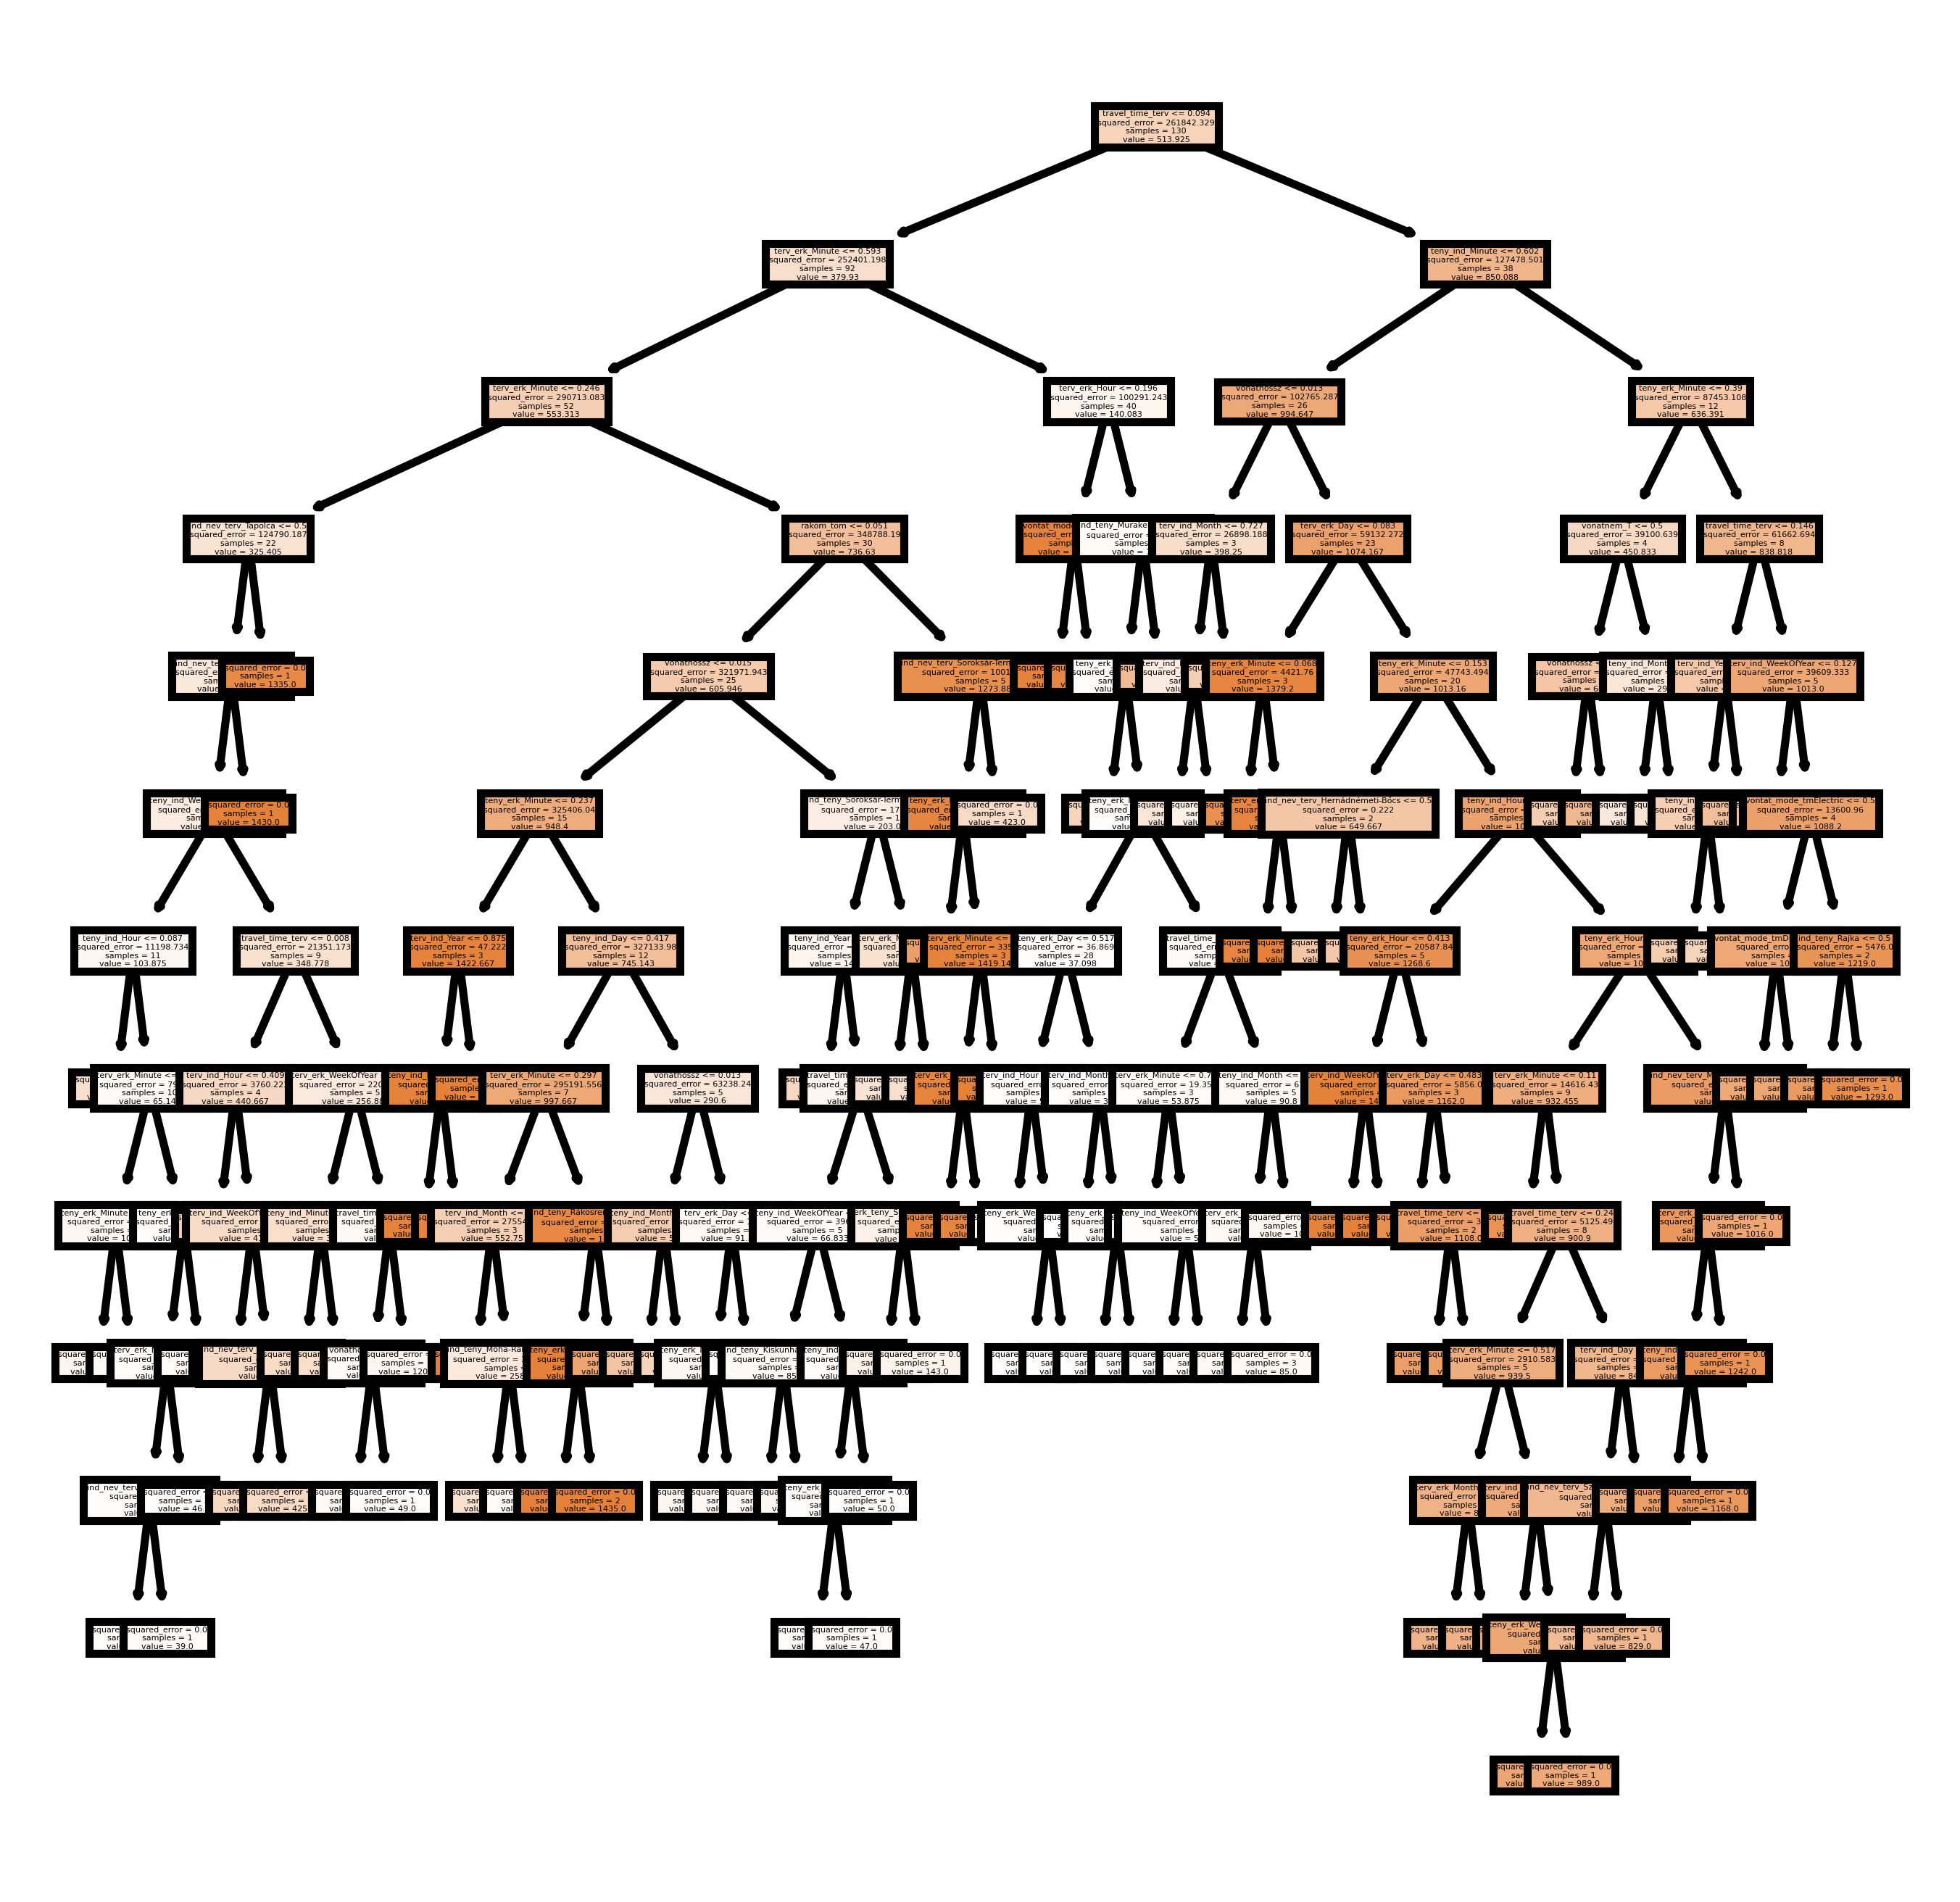

In [408]:
from sklearn import tree
fn=X_test.columns
cn=y.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(model.estimators_[0],
               feature_names = fn,
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

Összegezve: modellek teljesítménye

In [409]:

print("tanuló adatokra XGBRegressor")
print("mse: ",xgbRegressorTrainMSE)
print("mae: ",xgbRegressorTrainMAE)

print("\n")

print("teszt adatokra XGBRegressor")
print("mse: ",xgbRegressorTestMSE)
print("mae: ",xgbRegressorTestMAE)

print("\n")

print("tanuló adatokra XGBRegressor fontosabb oszlopai")
print("mse: ",xgbRegressorImportantTrainMSE)
print("mae: ",xgbRegressorImportantTrainMAE)

print("\n")

print("tanuló adatokra XGBRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",xgbRegressorGsHptTrainMSE)
print("mae: ",xgbRegressorGsHptTrainMAE)

print("\n")

print("teszt adatokra XGBRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",xgbRegressorGsHptTestMSE)
print("mae: ",xgbRegressorGsHptTestMAE)

print("\n")

print("tanuló adatokra RandomForestRegressor")
print("mse: ",randomForestRegressorTrainMSE)
print("mae: ",randomForestRegressorTrainMSE)

print("\n")

print("teszt adatokra RandomForestRegressor")
print("mse: ",randomForestRegressorTestMSE)
print("mae: ",randomForestRegressorTestMAE)

print("\n")

print("tanuló adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestRegressorGsHptTrainMSE)
print("mae: ",randomForestRegressorGsHptTrainMAE)

print("\n")

print("teszt adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestRegressorGsHptTestMSE)
print("mae: ",randomForestRegressorGsHptTestMAE)

print("\n")

print("Az összes adatra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestTreeGsHptAllMSE)
print("mae: ",randomForestTreeGsHptAllMAE)

tanuló adatokra XGBRegressor
mse:  1408.2170771990095
mae:  26.391661180768693


teszt adatokra XGBRegressor
mse:  223459.96544031374
mae:  322.5011644999186


tanuló adatokra XGBRegressor fontosabb oszlopai
mse:  1030.278554183159
mae:  22.595896625518797


tanuló adatokra XGBRegressor + GridSearch + Hyperparameter tunning
mse:  1.58224254067006e-07
mae:  0.00032217161996023994


teszt adatokra XGBRegressor + GridSearch + Hyperparameter tunning
mse:  365902.85799111065
mae:  414.30135679244995


tanuló adatokra RandomForestRegressor
mse:  28658.57133
mae:  28658.57133


teszt adatokra RandomForestRegressor
mse:  213030.14719500003
mae:  307.06983333333335


tanuló adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning
mse:  28133.350985698802
mae:  112.97122458460478


teszt adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning
mse:  502.46566820689236
mae:  16.500387754652248


Az összes adatra RandomForestRegressor + GridSearch + Hyperparameter tunning
m